---
## **A**bstract **S**yntax **T**ree
by Tobia Ippolito

---
### **Table of Contents**
- [Load Modules](#0.0)
- [Execute String as Python-Code](#1.0)
- [Use AST with Enviroments](#2.0)
- [Analysis with the AST](#3.0)
- [Show AST](#4.0)
<br>
<br>
---
### <a name="0.0">Load Modules</a>

Benötigt:
1. [Installiere Graphviz](https://graphviz.gitlab.io/_pages/Download/Download_windows.html)
2. pip install showast
3. (pip install matplotlib)

In [192]:
import showast
import ast

import matplotlib.pyplot as plt

---
### <a name="1.0">Execute String as Python-Code</a>
- ast.parse &nbsp;-> transforms a str in an AST <br>
- ast.dump &nbsp;-> makes an AST-Object readable<br>
- compile   &nbsp;&nbsp;-> Transforms an AST to Byte-Code (also can compile a str)
    - returns a Code-Object which can executed by eval or exec
    - mode:
        - eval - accepts only a single expression.
        - exec - It can take a code block that has Python statements, class and functions, and so on.

In [166]:
expression = '1+2'
ast_code = ast.parse(expression, mode='eval')

print(eval(compile(ast_code, '', mode='eval')))
print(ast.dump(ast_code))
print(ast_code)

3
Expression(body=BinOp(left=Constant(value=1), op=Add(), right=Constant(value=2)))


In [167]:
command = 'v = 1+2'
code = ast.parse(command)

exec(compile(code, '', mode='exec'))

print(v)
print(ast.dump(code))
print(code)

3
Module(body=[Assign(targets=[Name(id='v', ctx=Store())], value=BinOp(left=Constant(value=1), op=Add(), right=Constant(value=2)))], type_ignores=[])


---
### <a name="2.0">Use AST with Environments

In [168]:
code = """
message = 'moinselchen'
pi = 3.14
"""

ast_code = ast.parse(code)

compiled_code = compile(ast_code, filename='', mode='exec')
# will also work:
# compiled_code = compile(code, filename='', mode='exec')

compiled_code

<code object <module> at 0x000002748F1E2BE0, file "", line 2>

In [169]:
env = {}
exec(compiled_code, env)

env['message'], env['pi']

('moinselchen', 3.14)

---
### <a name="3.0">Analysis with the AST</a>
Use Nodes of the AST to analyse the Python-Code.

In [193]:
def load_code(path_to_file:str) -> ast.AST:
    #filename = 
    with open(path_to_file) as f:
        tree = ast.parse(f.read(), filename=path_to_file)

    return ast.parse(tree, filename=path_to_file, mode='exec')


def analyse_calls(tree, should_print=False) -> dict:
    calls = dict()
    for node in ast.walk(tree):
        if isinstance(node, ast.Call):
            call = node.func
            while True:
                if isinstance(call, ast.Attribute):
                    if type(call.value) == ast.Name and call.attr != None and len(call.attr) > 0:
                        call = f"{call.value.id}.{call.attr}"
                        break
                    call = call.value
                elif isinstance(call, ast.Call):
                    call = call.func
                elif isinstance(call, ast.Name):
                    call = call.id
                    break

            if call in calls.keys():
                calls[call] += 1
            else:
                calls[call] = 1

    if should_print:
        ordered_calls = sorted(calls.items(), key=lambda x: x[1], reverse=True)
        print("-------------------------------------")
        print("--------  Analysis of Calls  --------")
        print("-------------------------------------")
        print(f"There are {sum(calls.values())} calls.\n")
        for i, x in enumerate(ordered_calls):
            print(f"{x[1]}x {x[0]}")    # {i+1:02d}
        print("")

    return calls


def analyse_imports(tree, should_print=False) -> list:
    imports = []
    for node in ast.walk(tree):
        if isinstance(node, ast.Import):
            for name in node.names:
                imports += [f"{name.name}"]
        elif isinstance(node, ast.ImportFrom):
            for name in node.names:
                imports += [f"{node.module}.{name.name}"]

    if should_print:
        ordered_imports = sorted(imports, key=lambda x: x, reverse=False)
        print("-------------------------------------")
        print("-------  Analysis of Imports  -------")
        print("-------------------------------------")
        for i, x in enumerate(ordered_imports):
            print(f"- {x}")
        print("")

    return imports


def analyse_definitions(tree, should_print=False) -> None:
    defs = []
    lambdas = 0
    classes = []
    returns = 0
    yields = 0
    globals = 0
    nonlocals = 0

    for node in ast.walk(tree):
        if isinstance(node, ast.FunctionDef):
            defs += [node.name]
        elif isinstance(node, ast.Lambda):
            lambdas += 1
        elif isinstance(node, ast.ClassDef):
            classes += [node.name]
        elif isinstance(node, ast.Return):
            returns += 1
        elif isinstance(node, ast.Yield):
            yields += 1
        elif isinstance(node, ast.Global):
            globals += 1
        elif isinstance(node, ast.Nonlocal):
            nonlocals += 1

    if should_print:
        print("-------------------------------------")
        print("-----  Analysis of Definitions  -----")
        print("-------------------------------------")
        print(f"- Defined Functions ({len(defs)}):")
        for x in defs:
            print(f"    - {x}")
        print(f"\n- Defined Classes ({len(classes)}):")
        for x in classes:
            print(f"    - {x}")
        print(f"\n- Lambda Functions: {lambdas}")
        print(f"\n- Returns: {returns}")
        print(f"\n- Yields: {yields}")
        print(f"\n- global Keywords: {globals}")
        print(f"\n- nonlocal Keywords: {nonlocals}")
        print("")

    return None


# Control Flow
def analyse_structures(tree, should_print=False) -> None:
    ifs = 0
    fors = 0
    whiles = 0
    breaks = 0
    continues = 0
    tries = 0
    withs = 0

    for node in ast.walk(tree):
        if isinstance(node, ast.If):
            ifs += 1
        elif isinstance(node, ast.For):
            fors += 1
        elif isinstance(node, ast.While):
            whiles += 1
        elif isinstance(node, ast.Break):
            breaks += 1
        elif isinstance(node, ast.Continue):
            continues += 1
        elif isinstance(node, ast.Try):
            tries += 1
        elif isinstance(node, ast.With):
            withs += 1

    if should_print:
        print("-------------------------------------")
        print("-----  Analysis of Structures  ------")
        print("-------------------------------------")
        print(f"- Defined loops ({fors+whiles}):")
        print(f"    - For-Loops: {fors}")
        print(f"    - While-Loops: {whiles}")
        print(f"\n- Break's: {breaks}")
        print(f"\n- Continue's: {continues}")
        print(f"\n- If-Statements: {ifs}")
        print(f"\n- Try-Blocks: {tries}")
        print(f"\n- With-Blocks: {withs}")
        print("")

    return None


def analyse_operations(tree, should_print=False) -> list:
    operations = 0
    adds = 0
    subs = 0
    mults = 0
    divs = 0
    mods = 0
    floor_divs = 0
    pows = 0

    bool_operations = 0
    ands = 0
    ors = 0
    equals = 0
    not_equals = 0
    is_ = 0
    is_not = 0
    ins = 0
    not_ins = 0
    
    for node in ast.walk(tree):

        if isinstance(node, ast.BinOp):
            operations += 1
        elif isinstance(node, ast.BoolOp) or isinstance(node, ast.Compare):
            bool_operations += 1

        # OP's
        if isinstance(node, ast.Add):
            adds += 1
        elif isinstance(node, ast.Sub):
            subs += 1
        elif isinstance(node, ast.Mult):
            mults += 1
        elif isinstance(node, ast.Div):
            divs += 1
        elif isinstance(node, ast.Mod):
            mods += 1
        elif isinstance(node, ast.FloorDiv):
            floor_divs += 1
        elif isinstance(node, ast.Pow):
            pows += 1
        # OP-BOOL's
        elif isinstance(node, ast.And):
            ands += 1
        elif isinstance(node, ast.Or):
            ors += 1
        elif isinstance(node, ast.Eq):
            equals += 1
        elif isinstance(node, ast.NotEq):
            not_equals += 1
        elif isinstance(node, ast.Is):
            is_ += 1
        elif isinstance(node, ast.IsNot):
            is_not += 1
        elif isinstance(node, ast.In):
            ins += 1
        elif isinstance(node, ast.NotIn):
            not_ins += 1

    if should_print:
        print("-------------------------------------")
        print("-----  Analysis of Operations  ------")
        print("-------------------------------------")
        print(f"- Operations ({operations}):")
        print(f"    - Add's: {adds}")
        print(f"    - Sub's: {subs}")
        print(f"    - Mult's: {mults}")
        print(f"    - Div's: {divs}")
        print(f"    - Mod's: {mods}")
        print(f"    - Floor Div's: {floor_divs}")
        print(f"    - Pow's: {pows}")
        print(f"\n- Bool Operations ({bool_operations}):")
        print(f"    - And's: {ands}")
        print(f"    - Or's: {ors}")
        print(f"    - Equals's: {equals}")
        print(f"    - Not Equals's: {not_equals}")
        print(f"    - Is's: {is_}")
        print(f"    - Is not's: {is_not}")
        print(f"    - In's: {ins}")
        print(f"    - Not In's: {not_ins}")
        print("")

    return [('Add', adds), ('Sub', subs), ('Mult', mults), ('Div', divs), ('Mod', mods), ('Floor Div', floor_divs), ('Pow', pows), 
            ('And', ands), ('Or', ors), ('Equal', equals), ('Not Equal', not_equals), ('Is', is_), ('Is Not', is_not), ('In', ins), ('Not In', not_ins)]

In [239]:
def visualize(calls:dict, imports:list, ops:list):
    plt.style.use('seaborn-whitegrid')
    fig, ax = plt.subplots(2, 1, figsize=(20, 10))
    
    x = []
    y = []
    counter = 0
    for name, value in sorted(calls.items(), key=lambda x: x[1], reverse=True):
        if counter >= 10:
            break
        x += [name]
        y += [value]
        counter += 1

    ax[0].set_title("Popular Function-Calls")
    ax[0].bar(x, y, align='center', width=0.5)

    x = []
    y = []
    for name, value in ops:
        x += [name]
        y += [value]
    ax[1].set_title("Operations")
    ax[1].bar(x, y)

    plt.show()

In [197]:
def analyse_code(path_to_file:str, should_print=False, should_visualize=False):
    # Analysis
    if should_print:
        title = f"    >>> Analysis of {path_to_file.split('/')[-1]} <<<    "
        print("_"*len(title))
        print(f"{title}\n")
    tree = load_code(path_to_file)
    calls = analyse_calls(tree, should_print)
    imports = analyse_imports(tree, should_print)
    analyse_definitions(tree, should_print)
    analyse_structures(tree, should_print)
    operations = analyse_operations(tree, should_print)
    if should_print:
        print(f"\n{' '*(len(title)//2-11)}>>> END of Analysis <<<")
        print("_"*len(title))

    # Visualisation
    if should_visualize:
        visualize(calls, imports, operations)

_______________________________________
    >>> Analysis of heapsort.py <<<    

-------------------------------------
--------  Analysis of Calls  --------
-------------------------------------
There are 25 calls.

7x self.assertEqual
6x heapifyFull
5x heapify
2x len
2x range
2x unittest.main
1x self.allTestsForSortAlgorithm

-------------------------------------
-------  Analysis of Imports  -------
-------------------------------------
- SortTest
- __future__.annotations
- unittest

-------------------------------------
-----  Analysis of Definitions  -----
-------------------------------------
- Defined Functions (12):
    - heapifyFull
    - heapify
    - sort
    - swap
    - testHeapSort
    - testHeapify1
    - testHeapify2
    - testHeapify3
    - testHeapify4
    - testHeapify5
    - testHeapify6
    - testHeapify7

- Defined Classes (1):
    - HeapSortTest

- Lambda Functions: 0

- Returns: 1

- Yields: 0

- global Keywords: 0

- nonlocal Keywords: 0

-----------------------

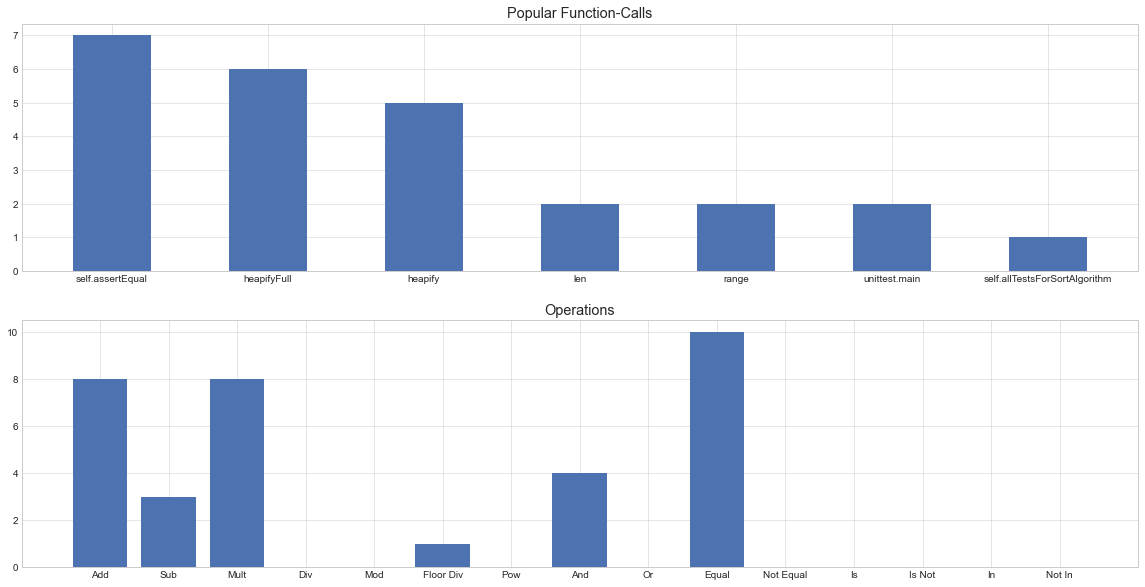

In [240]:
#analyse_code('./res/call_test.py', True)
#analyse_code('./res/guess.py', True)
#analyse_code('./res/ImmutableList.py', True, True)
analyse_code('./res/heapsort.py', True, True)

---
### <a name="4.0">Show AST</a>

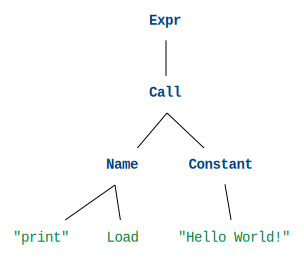

In [173]:
%%showast
print("Hello World!")

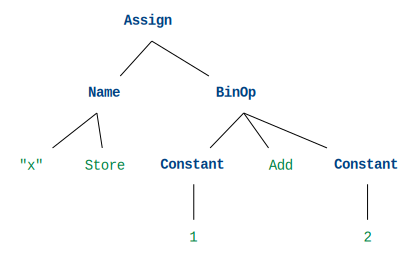

In [174]:
%%showast
x = 1 + 2

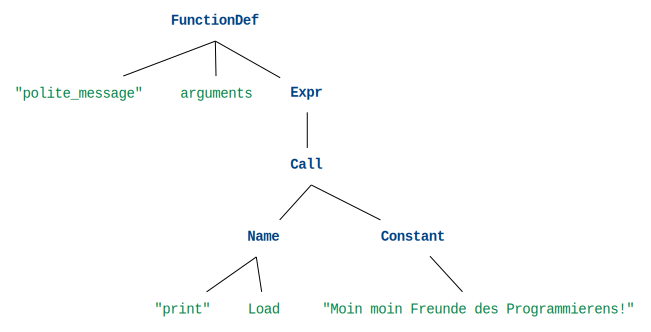

In [175]:
def polite_message():
    print("Moin moin Freunde des Programmierens!")

showast.show_source(polite_message)

---